# Number multi-label classification using Keras
---

In [1]:
import numpy as np
import pandas as pd

from skmultilearn.dataset import available_data_sets, load_dataset

import csv
from scipy.io import arff
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout

Using TensorFlow backend.
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jakub/Dokumenty/venv36/lib/pytho

In [2]:
print('Tensorflow:', tf.__version__)

Tensorflow: 2.0.0-beta1


In [3]:
TRAIN_RATIO, TEST_RATIO = 0.6, 0.7

## Data loading
---
><div class="row">
>  <div class="col-md-4" markdown="1">
>      Numeric data
>  </div>
>    <div class="col-md-4" markdown="1">
>      multi-label
>  </div>
>  <div class="col-md-4" markdown="1">
>      classification.
>  </div>
></div>

In [4]:
data = load_dataset('enron', 'undivided')

enron:undivided - exists, not redownloading


In [5]:
attributes = np.array([a[0] for a in data[2]])
attributes

array(['0', '00', '000', ..., 'years', 'yesterday', 'york'], dtype='<U14')

In [6]:
classes = np.array([c[0] for c in data[3]])
classes

array(['A.A8', 'C.C9', 'B.B12', 'C.C11', 'C.C5', 'C.C7', 'B.B2', 'B.B3',
       'D.D16', 'A.A7', 'D.D1', 'A.A4', 'C.C2', 'A.A3', 'A.A1', 'D.D9',
       'D.D19', 'B.B8', 'D.D12', 'D.D6', 'C.C8', 'A.A6', 'B.B9', 'A.A5',
       'C.C10', 'B.B1', 'D.D5', 'B.B11', 'D.D2', 'B.B4', 'D.D15', 'C.C4',
       'D.D8', 'B.B6', 'D.D3', 'D.D13', 'D.D7', 'C.C12', 'B.B7', 'C.C6',
       'B.B5', 'D.D11', 'A.A2', 'C.C3', 'D.D10', 'D.D18', 'B.B13',
       'D.D17', 'B.B10', 'C.C1', 'D.D4', 'C.C13', 'D.D14'], dtype='<U5')

In [7]:
X = csr_matrix(data[0]).toarray()
X.shape

(1702, 1001)

In [8]:
y = csr_matrix(data[1]).toarray()
y.shape

(1702, 53)

## Classs weighting
---
Dealing with imbalanced classes.

In [9]:
counts = np.array(np.sum(y, axis=0)).flatten()
counts

array([ 26,  64,   6,  26, 108,  83, 913,  42,  10,  25,  12, 533, 125,
       165, 855,  18,   9,  22,  38,  21, 107, 176,  55,  96,  77, 680,
        13,   7,  20, 124,   3,  63,   7,  25,  22,   8,  13,  33,  13,
       249,  15,  28,  49,  71, 130,   1, 311,   2,  18, 203,  20,   7,
         3])

In [10]:
weights = np.array([np.size(counts)/np.float32(c) for c in counts])
weights

array([ 2.03846154,  0.828125  ,  8.83333333,  2.03846154,  0.49074074,
        0.63855422,  0.05805038,  1.26190476,  5.3       ,  2.12      ,
        4.41666667,  0.09943715,  0.424     ,  0.32121212,  0.0619883 ,
        2.94444444,  5.88888889,  2.40909091,  1.39473684,  2.52380952,
        0.4953271 ,  0.30113636,  0.96363636,  0.55208333,  0.68831169,
        0.07794118,  4.07692308,  7.57142857,  2.65      ,  0.42741935,
       17.66666667,  0.84126984,  7.57142857,  2.12      ,  2.40909091,
        6.625     ,  4.07692308,  1.60606061,  4.07692308,  0.21285141,
        3.53333333,  1.89285714,  1.08163265,  0.74647887,  0.40769231,
       53.        ,  0.17041801, 26.5       ,  2.94444444,  0.26108374,
        2.65      ,  7.57142857, 17.66666667])

In [11]:
class_weight = dict({i: w for i, w in enumerate(weights)})    

## Model
---

In [12]:
X_train, X_val, X_test = X[:int(len(X)*TRAIN_RATIO)], X[int(len(X)*TRAIN_RATIO):int(len(X)*TEST_RATIO)], X[int(len(X)*TEST_RATIO):]
y_train, y_val, y_test = y[:int(len(y)*TRAIN_RATIO)], y[int(len(y)*TRAIN_RATIO):int(len(y)*TEST_RATIO)], y[int(len(y)*TEST_RATIO):]

print(f'X_train: {X_train.shape} | y_train: {y_train.shape}')
print(f'X_val: {X_val.shape} | y_val: {y_val.shape}')
print(f'X_test: {X_test.shape} | y_test: {y_test.shape}')

X_train: (1021, 1001) | y_train: (1021, 53)
X_val: (170, 1001) | y_val: (170, 53)
X_test: (511, 1001) | y_test: (511, 53)


In [13]:
INIT = 'random_uniform'
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 20

In [14]:
inputs = Input(shape=(1001, ), name='numeric_data')
h = Dense(512, activation='relu', name='dense_0', kernel_initializer=INIT, bias_initializer=INIT)(inputs)
h = Dense(256, activation='relu', name='dense_1', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dropout(0.1, name='dropout_0')(h)
h = Dense(128, activation='relu', name='dense_2', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dense(64, activation='relu', name='dense_3', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dropout(0.1, name='dropout_1')(h)
outputs = Dense(53, activation='sigmoid', name='predictions', kernel_initializer=INIT, bias_initializer=INIT)(h)

NN = Model(inputs=inputs, outputs=outputs, name='numeric_multilabel_classifier')

In [16]:
NN.summary()

Model: "numeric_multilabel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
numeric_data (InputLayer)    [(None, 1001)]            0         
_________________________________________________________________
dense_0 (Dense)              (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_0 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6

In [17]:
NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
           loss=tf.keras.losses.BinaryCrossentropy(),
           metrics=[tf.keras.metrics.BinaryAccuracy()])

In [18]:
tqdm_callback = TQDMNotebookCallback()
fit_results = NN.fit(X_train, y_train, class_weight=class_weight, batch_size=BATCH_SIZE, epochs=EPOCHS,
                     validation_data=(X_val, y_val), verbose=0, callbacks=[tqdm_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
predictions = NN.predict(X_test)

In [20]:
def training_progress_plot(results, title, save_file=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.array(results.epoch)+1)
    
    ax1.set_ylabel('Binary accuracy', color='r')
    ax1.plot(np.array(results.epoch)+1, results.history['binary_accuracy'], 'r-', label='accuracy')
    ax1.plot(np.array(results.epoch)+1, results.history['val_binary_accuracy'], 'r--', label='val. accuracy')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='center')
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Binary loss', color='b')
    ax2.plot(np.array(results.epoch)+1, results.history['loss'], 'b-', label='loss')
    ax2.plot(np.array(results.epoch)+1, results.history['val_loss'], 'b--', label='val. loss')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='center right')
    
    fig.tight_layout()
    plt.title(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

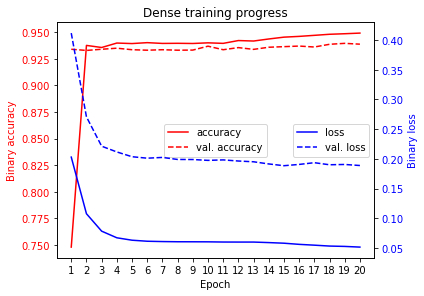

In [21]:
training_progress_plot(fit_results, title='Dense training progress',
                       save_file='ml_class_numeric/training_progress.png')

## Predictions
---

In [22]:
PRED_THR = 0.09

In [23]:
# find best accuracy values in given prediction threshold values
pred_thrs = np.arange(0.09, 0.4, 0.0001)
pred_thrs

array([0.09  , 0.0901, 0.0902, ..., 0.3998, 0.3999, 0.4   ])

In [24]:
# accuracy measure for flattened zero-one arrays
def binary_flatten_accuracy(y_true, y_pred):
    cm = tf.math.confusion_matrix(y_true.flatten(), y_pred.flatten()).numpy()
    return float(np.sum(np.diag(cm)))/np.sum(np.sum(cm))

# accuracy measure for labeled (different length) arrays
def exact_match_ratio(y_true, y_pred):
    matches = 0.
    for y_t, y_p in zip(y_true, y_pred):
        if np.array_equal(sorted(y_t), sorted(y_p)):
            matches += 1.
    return matches/y_true.shape[0]

# accuracy measure for labeled (different length) arrays
def multilabel_accuracy(y_true, y_pred):
    score = 0.
    for y_t, y_p in zip(y_true, y_pred):
        score += np.float32(np.size(np.intersect1d(y_t, y_p)))/np.size(np.union1d(y_t, y_p))
    
    return score/y_true.shape[0]

In [25]:
def accuracy_depencies(labels, logits, thr_s, save_file=None):
    dependencies = list([])
    for thr in tqdm(thr_s):
        y_true = np.array(labels)
        y_pred = np.array([np.vectorize(lambda p: 1 if p>thr else 0)(l) for l in logits])
        
        num_y_true = np.array([np.where(l==1)[0] for l in y_true])
        num_y_pred = np.array([np.where(l==1)[0] for l in y_pred])
        
        bf_acc = binary_flatten_accuracy(y_true, y_pred)
        emr = exact_match_ratio(num_y_true, num_y_pred)
        ml_acc = multilabel_accuracy(num_y_true, num_y_pred)
        
        dependencies.append([thr, bf_acc, emr, ml_acc])
    
    # build dataframe
    df = pd.DataFrame(dependencies,
                      columns=['threshold', 'flat. acc.', 'em. ratio', 'ml. acc.'])
    df = df.set_index('threshold')
    
    if save_file:
        df.to_csv(save_file)
    return df

In [26]:
acc_dep = accuracy_depencies(labels=y_test, logits=predictions, thr_s=pred_thrs,
                             save_file='ml_class_numeric/accuracy_depencies.csv')
acc_dep

,flat. acc.,em. ratio,ml. acc.
threshold,,,
0.0900,0.830816,0.0,0.212889
0.0901,0.831038,0.0,0.212975
0.0902,0.831149,0.0,0.212698
0.0903,0.831370,0.0,0.212926
0.0904,0.831592,0.0,0.213268
...,...,...,...
0.3996,0.936418,0.0,0.179857
0.3997,0.936344,0.0,0.178925
0.3998,0.936344,0.0,0.178925


In [27]:
def accuracy_dependecies_plot(df, title, save_file=None):
    plt.figure(figsize=(16, 4))
    
    x_space = df.index.values
    plt.plot(x_space, df['flat. acc.'].values, label='flattened accuracy')
    plt.plot(x_space, df['em. ratio'].values, label='exact match ratio')
    plt.plot(x_space, df['ml. acc.'].values, label='multilabel accuracy')
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction threshold')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

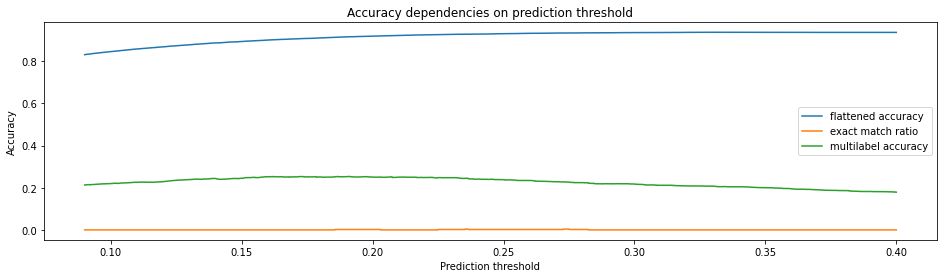

In [28]:
accuracy_dependecies_plot(acc_dep, title='Accuracy dependencies on prediction threshold',
                          save_file='ml_class_numeric/accuracy_depencies.png')

In [29]:
print(f'Max flattened binary accuracy {np.round(acc_dep["flat. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["flat. acc."].argmax()], 4)} prediction threshold.')
print(f'Max exact match ratio {np.round(acc_dep["em. ratio"].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["em. ratio"].argmax()], 4)} prediction threshold.')
print(f'Max multilabel accuracy {np.round(acc_dep["ml. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["ml. acc."].argmax()], 4)} prediction threshold.')

Max flattened binary accuracy 0.9371 for 0.3389 prediction threshold.
Max exact match ratio 0.0039 for 0.2353 prediction threshold.
Max multilabel accuracy 0.2534 for 0.1732 prediction threshold.
